Kvasir dataset split into neg/pos and trained using Resnet50 without augmentation. Getting some decent results after training on resampled data with large step-size.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henrik/master-thesis/data/kvasir-v2/')

config = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'kva',
    "resample": False,
    "shuffle_buffer_size": 1000,
    "neg_class": ['normal-cecum'],
    "outcast": None,
    # Model
    "model": 'EfficientNetB0',
    "num_epochs": 2,
    "batch_size": 64,
    "img_shape": (64, 64, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": True,
    "checkpoint": False,
    "early_stopping": False,
    "early_stopping_patience": 10,
    "decay_rate": 0.05,              # higher number gives steeper dropoff
    # Misc
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

fine_tune_from = 130
fine_tune_epochs = 30
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]

normal-z-line               : 1000 | 12.50%
dyed-resection-margins      : 1000 | 12.50%
normal-pylorus              : 1000 | 12.50%
dyed-lifted-polyps          : 1000 | 12.50%
esophagitis                 : 1000 | 12.50%
polyps                      : 1000 | 12.50%
ulcerative-colitis          : 1000 | 12.50%
normal-cecum                : 1000 | 12.50%

Total number of images: 8000, in 8 classes.

Dataset.list_files:  /home/henrik/master-thesis/data/kvasir-v2/*/*.*g 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Cell is empty
[4 4 0 0 0 6 1 0 4 2]
[6 0 4 7 7 3 3 6 6 3]
[2 0 7 5 4 1 1 7 5 3]
[3 2 5 0 2 4 6 1 1 0]
[0 3 7 6 2 1 2 0 5 1]
[5 4 4 4 2 6 6 7 6 0]
[6 0 0 6 6 2 1 5 4 7]
[0 3 3 3 7 5 3

# Step 1
Train a teacher model on labeled images

In [4]:
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras import layers

### Create and compile the model

In [5]:
from efficientnet import EfficientNetB0 as EfficientNet

# from efficientnet import center_crop_and_resize, preprocess_input

Using TensorFlow backend.


In [6]:
efficientnet_base = EfficientNet(
    weights="imagenet", # or weights='noisy-student'
    include_top=False, 
    input_shape=config["img_shape"]
)

In [7]:
# Freeze layers in resnet
efficientnet_base.trainable = True

# Define model
en_model = Sequential()

en_model.add(efficientnet_base)
en_model.add(layers.GlobalAveragePooling2D())
# en_model.add(layers.Dropout(0.2))
# en_model.add(layers.Dense(256, activation='relu'))
en_model.add(layers.Dense(params["num_classes"], activation=config["final_activation"]))

if config['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])
elif config['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=config["learning_rate"])

en_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [8]:
en_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 2, 2, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 10248     
Total params: 4,059,812
Trainable params: 4,017,796
Non-trainable params: 42,016
_________________________________________________________________


### Callbacks

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

In [10]:
# By using LearnignRateScheduler
initial_learning_rate = config["learning_rate"]
decay_steps = params["train_size"] // config["batch_size"]
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if config["early_stopping"]: callbacks.append(earlystopp_cb)
if config["learning_schedule"]: callbacks.append(lr_schedule_cb)
if config["checkpoint"]: callbacks.append(checkpoint_cb)

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write(str(config))
f.close()

In [11]:
train_steps

87

In [13]:
history = en_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 87 steps, validate for 18 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/2
87/87 [==============================] - 10s 114ms/step - loss: 1.4391 - sparse_categorical_accuracy: 0.5038 - val_loss: 56800.4210 - val_sparse_categorical_accuracy: 0.1233

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009645232815964523.
Epoch 2/2
87/87 [==============================] - 4s 44ms/step - loss: 0.7008 - sparse_categorical_accuracy: 0.6785 - val_loss: 6.1750 - val_sparse_categorical_accuracy: 0.4297


In [14]:
best_acc =  str(history.history["val_sparse_categorical_accuracy"][-1])[2:4]
# en_model.save('./models/{}.h5'.format(model_name+best_acc))

## Evaluate the model

In [15]:
en_evaluate = en_model.evaluate(val_ds, verbose=2, steps=val_steps)

# Write evaluate dictionary to text file
f = open(log_dir+"/evaluate.txt","w")
f.write( str(en_evaluate) )
f.close()

18/18 - 0s - loss: 6.4200 - sparse_categorical_accuracy: 0.4523


In [16]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

if config["learning_schedule"]: lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

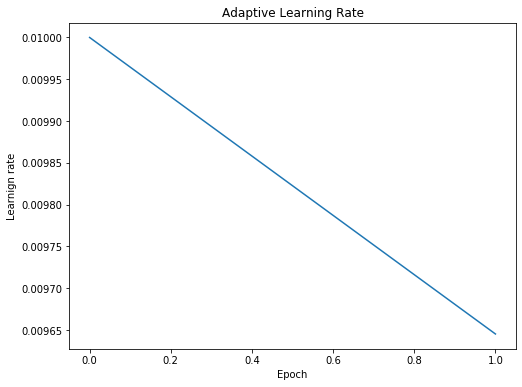

In [17]:
if config["learning_schedule"]:
    # Plot the learning rate
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, lr, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learnign rate')
    plt.savefig(log_dir+'/learning_rate.png')
    plt.title('Adaptive Learning Rate');

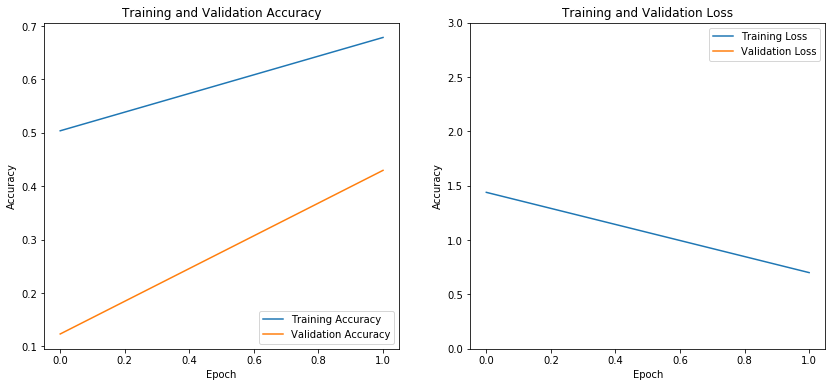

In [18]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.png')
plt.show()

#### Check the predictions on validation dataset

label: dyed-resection-margins

99.93% dyed-resection-margins


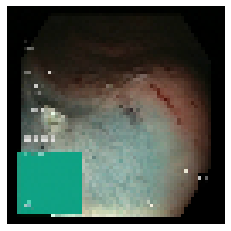

In [19]:
# Take one batch of validation data
idx = np.random.randint(0, config["batch_size"])
for images, labels in val_ds.take(1):
    # Take one image and convert it to numpy
    img = images.numpy()[idx]
    lab = labels.numpy()[idx]
    # Add one dimension
    print ("label:", class_names[lab], end='\n\n')
    show_image(img)
    img = np.expand_dims(img, 0)
    
    prediction = en_model.predict(img, verbose=0)
    for i, pred in enumerate(prediction[0]):
        if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

Read in the unlabeled `test` dataset (which are images taken from the training data)

In [20]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [config["img_shape"][0], config["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [54]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled_test = pathlib.Path('/home/henrik/master-thesis/data/kvasir-v2-unlabeled/')

ds_size_unlabeled_test = len(list(data_dir_unlabeled_test.glob('*.*g')))

files_string = str(data_dir_unlabeled_test/'*.*g')
list_ds_unlabeled_test = tf.data.Dataset.list_files(files_string)

unlabeled_ds_test = list_ds_unlabeled_test.map(process_path, num_parallel_calls=AUTOTUNE)

Next hurdle: get access to both dataset sample and prediction.  
- Predict one and one image?
- Predict all at once?  

This method works, but predicts one image at a time.. Slow?

In [55]:
# Batch unlabeled_ds
unlabeled_ds_test = unlabeled_ds_test.batch(5)

In [56]:
unlabeled_ds_test

<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.string)>

In [133]:
# Create a dataset with 1 sample from training dataset
for img, lab in train_ds.unbatch().take(1):
    pass

new_samples = tf.data.Dataset.from_tensors((img, lab))

In [134]:
pred_confidence = 0.80
# new_samples = tf.data.Dataset

new_samples_counter = 0
for batch in unlabeled_ds_test:
    images, filenames = batch
    batch_preds = en_model.predict(images, verbose=0)
    
    for pred, image in zip(batch_preds, images):
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)
            pred_class = class_names[pred_idx]
            
#             print("{:>5.2f}% {}".format(highest_pred*100, pred_class))
            
            # Make a tensor of the unlabeled sample
            new_sample = tf.data.Dataset.from_tensors((image, pred_idx))
#             new_samples.append(new_sample)
            new_samples = new_samples.concatenate(new_sample)
            new_samples_counter += 1
        
print ("Added", new_samples_counter, "new samples to the training dataset")

Added 33 new samples to the training dataset


In [137]:
# Merge new dataset with original
new_ds = train_ds.unbatch().take(params["train_size"]).concatenate(new_samples.skip(1))

In [138]:
counter = 0
for img, label in new_ds:
    counter += 1
    
print (counter)

5633


Filename: 0a613579-3062-405e-b6c2-10fd9c46226c.jpg

99.98% normal-pylorus


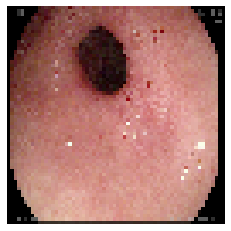

In [22]:
# Take one image of unlabeled-test set
for img, name in unlabeled_ds_test.take(1):
    # Convert to numpy and add dimension
    print ("Filename:", str(name.numpy())[2:-1], end='\n\n')
    show_image(img.numpy())
    img = np.expand_dims(img.numpy(), 0)
    prediction = en_model.predict(img, verbose=0)
    for i, pred in enumerate(prediction[0]):
        if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

In [32]:
pred_label = np.argmax(prediction).astype(np.int32)
pred_image = img[-1] # drop one rank

# Make a tensor of the unlabeled sample
test = tf.data.Dataset.from_tensors((pred_image, pred_label))

In [44]:
# Add new sample to the training dataset
new_ds = train_ds.unbatch().take(params["train_size"]).concatenate(test)

In [58]:
counter = 0
for img, label in unlabeled_ds_test.take(1):
    print (img.shape)
    counter += 1
    
print (counter)

(5, 64, 64, 3)
1


In [ ]:
# Batch dataset
new_ds_batched = new_ds.batch(config["batch_size"])

In [ ]:
# Train (preferably new model) on the new training dataset
hist = en_model.fit(
    new_ds_batched,
#     steps_per_epoch = 40,
    epochs = 2,
    validation_data = test_ds,
#     validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)